### Homework 3 - Asset Pricing Theory

### 1. Follow the provided guidance

#### 1.2 Packages

In [2]:
import pandas as pd

In [3]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
pip install wrds

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
pip install python-dotenv

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


#### 1.5 Automatic authentication with .pgpass file

In [7]:
 #import wrds
 #db = wrds. Connection ()

import os
import wrds
from dotenv import load_dotenv
load_dotenv
WRDS_USERNAME = os.getenv("wrdsname")
db = wrds.Connection(wrds_username = WRDS_USERNAME)

WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


#### 1.7 Compustat Data

In [8]:
var_list = {
"comp_annual": "fyear, fyr, ceq, txditc, pstkl, pstkrv, pstk", # Add up the annual Compustat variables you need
"crsp_monthly": "ret, retx, shrout, prc, cfacpr" # Add up the monthly CRSP variables you need
}

datestart = '1963-01-01' # Change to your desired start date
dateend = '2023-12-31' # Change to your desired end date

compa_query = f"""
SELECT gvkey, datadate AS date, {var_list["comp_annual"]}
FROM comp.funda
WHERE indfmt='INDL' AND datafmt='STD' AND popsrc='D' AND consol='C'
AND datadate BETWEEN '{datestart}' AND '{dateend}'
"""
df_comp_a = db.raw_sql(compa_query)

#### 1.8 CRSP Data
crsp.dsf -> monthly stock market data \
crsp.msf -> daily stock market data 

permco -> company \
permno -> security

In [20]:
crspm_query = f"""
SELECT DISTINCT
a.permno, a.permco, a.date, {var_list["crsp_monthly"]},
b.shrcd, b.exchcd, b.siccd,
c.dlret, c.dlstcd
FROM crsp.msf AS a
INNER JOIN crsp.msenames AS b
    ON a.permno = b.permno
    AND b.namedt <= a.date
    AND a.date <= b.nameendt
    AND b.exchcd BETWEEN 1 AND 3
LEFT JOIN crsp.msedelist AS c
    ON a.permno = c.permno
    AND a.date = c.dlstdt
    WHERE a.date BETWEEN '{datestart}' AND '{dateend}'
    AND a.prc IS NOT NULL
    ORDER BY a.permno, a.permco, a.date
"""
df_crsp_m = db.raw_sql(crspm_query)

#### 1.9 CRSP-Compustat linktable

gvkey -> firm \
permno -> security

In [10]:
compa_query = f"""
    WITH ccm AS (
        SELECT gvkey, lpermno AS permno, lpermco AS permco, linkdt,
    linkenddt, linktype, linkprim
        FROM crsp.ccmxpf_linktable
        WHERE linktype IN ('LU', 'LC')
        AND linkprim IN ('P', 'C')
    ),  
    annual AS (
        SELECT gvkey, datadate AS date, {var_list["comp_annual"]}
        FROM comp.funda
        WHERE indfmt = 'INDL' AND datafmt = 'STD' AND consol = 'C' AND
    popsrc = 'D'
        AND datadate BETWEEN '{datestart}' AND '{dateend}'
    )
    SELECT DISTINCT
        ccm.permno, ccm.permco, annual.date, {var_list["comp_annual"]}
    FROM ccm
    INNER JOIN annual
        ON ccm.gvkey = annual.gvkey
        AND annual.date >= ccm.linkdt
        AND (ccm.linkenddt >= annual.date OR ccm.linkenddt IS NULL)
    ORDER BY ccm.permno, ccm.permco, annual.date;
"""
df_comp_a = db.raw_sql(compa_query)


####  1.10 Merging Compustat and CRSP

#### 1.11  Remove the duplicate gvkey-datadate when using Compustat data

In [11]:
import pandas as pd

# Ensure 'permno' and 'date' are in the correct format
df_comp_a['date'] = pd.to_datetime(df_comp_a['date'])
df_comp_a['permno'] = df_comp_a['permno'].astype(int)
                                  
# There is no duplicates in annual Compustat data
duplicates = df_comp_a[df_comp_a.duplicated(subset =['permno', 'date'], keep
=False)]
print(duplicates)

Empty DataFrame
Columns: [permno, permco, date, fyear, fyr, ceq, txditc, pstkl, pstkrv, pstk]
Index: []


#### 1.12  Adjust the Compustat data date


In [25]:
import datetime
import calendar

def apd_months (sourcedate, months):
    """
    Adds a specified number of months to a given date.

    Args:
        sourcedate (datetime.date): The original date.
        months(int): Number of months to add.
    """
    month = sourcedate.month - 1 + months
    year = sourcedate.year + month // 12 # year will be the same unless shifting by more than 11 months
    month = month % 12 + 1
    day = calendar.monthrange(year, month)[1]

    return datetime.date(year, month, day)

df_comp_a ['date'] = df_comp_a ['date'].apply(lambda x: apd_months (x, 6))


#### 1.13  Merge Compustat and CRSP

In [30]:
def expand_to_monthly (df , freq='Y'):
    """
    Expands annual or quarterly data into monthly data.

    Parameters:
    - df (pd.DataFrame): Input DataFrame containing 'date '.
    - freq (str): 'Y' for annual data , 'Q' for quarterly data.

    Returns:
    - pd.DataFrame: Expanded dataset with monthly frequency.
    """
    # Define mapping for expansion
    expand_map = {'Y': 12, 'Q': 3}
    if freq not in expand_map:
        raise ValueError("freq must be 'Y' (annual) or 'Q' (quarterly).")

    expand_count = expand_map[freq]

    # Ensure 'date' is datetime
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
                                 
    # Expand data by repeating rows
    df_expanded = df.loc[df.index.repeat( expand_count )].reset_index(drop=
    True)

    # Create month offset (0 ,1 ,2 ,...)
    df_expanded['month_offset'] = df_expanded.groupby(['permno', 'date']).cumcount()

    # Adjust date
    df_expanded['date'] = df_expanded['date'] + df_expanded['month_offset'].apply(lambda x: pd.DateOffset(months=int(x)))
    df_expanded['date'] = df_expanded['date'] + pd.offsets.MonthEnd(0)
    df_expanded['date'] = pd. to_datetime(df_expanded ['date'])

    df_expanded.drop(columns =['month_offset'], inplace=True)

    return df_expanded

df_comp_a_monthly = expand_to_monthly(df_comp_a , freq='Y')


C:\Users\65610\AppData\Local\Temp\ipykernel_14612\804833321.py:31: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  df_expanded['date'] = df_expanded['date'] + df_expanded['month_offset'].apply(lambda x: pd.DateOffset(months=int(x)))


In [31]:
def merge_comp_and_crsp(df_comp_monthly, df_crsp_monthly):
    """
    Merges monthly Compustat data with monthly CRSP data.

    Parameters:
    - df_comp_monthly (pd.DataFrame): Monthly Compustat dataset.
    - df_crsp_monthly (pd.DataFrame): Monthly CRSP dataset.

    Returns:
    - pd.DataFrame: Merged dataset with monthly frequency.
    """
    # Remove permco from CRSP to prevent duplicates during merging with Compustat
    df_crsp_monthly = df_crsp_monthly.drop(columns =['permco'])

    df_crsp_monthly['date'] = pd.to_datetime(df_crsp_monthly ['date']) + pd.offsets.MonthEnd(0)
    df_comp_monthly['date'] = pd.to_datetime(df_comp_monthly ['date']) + pd.offsets.MonthEnd(0)

    # Define merge keys
    merge_keys = ['date', 'permno']

    # Perform an inner join to keep only matching records
    df_merged = pd.merge(df_comp_monthly, df_crsp_monthly, on=merge_keys, how='inner')

    # Drop duplicates
    df_merged = df_merged.drop_duplicates(subset =['date', 'permno'])
    return df_merged

df_merged = merge_comp_and_crsp(df_comp_a_monthly , df_crsp_m)
df_merged = df_merged.sort_values(['permno', 'date'], ascending = [True, True])

### 2. Only collect the columns that are strictly necessary for your computations. (OPEN-TO-DO)

### 3.  Ensure your dataset only contains ordinary shares (shrcd = 10 or 11).

In [37]:
df_merged.head()

,permno,permco,date,fyear,fyr,ceq,txditc,pstkl,pstkrv,pstk,ret,retx,shrout,prc,cfacpr,shrcd,exchcd,siccd,dlret,dlstcd
0,10000,7952.0,1987-04-30,1986,10,0.418,0.0,0.0,0.0,0.0,-0.0625,-0.0625,3893.0,-0.23438,1.0,10,3,3990,<NA>,<NA>
1,10000,7952.0,1987-05-31,1986,10,0.418,0.0,0.0,0.0,0.0,-0.066667,-0.066667,3893.0,-0.21875,1.0,10,3,3990,<NA>,<NA>
2,10001,7953.0,1986-12-31,1986,6,5.432,1.605,0.0,0.0,0.0,0.015,0.0,991.0,7.0,3.0,11,3,4920,<NA>,<NA>
3,10001,7953.0,1987-01-31,1986,6,5.432,1.605,0.0,0.0,0.0,-0.035714,-0.035714,991.0,6.75,3.0,11,3,4920,<NA>,<NA>
4,10001,7953.0,1987-02-28,1986,6,5.432,1.605,0.0,0.0,0.0,-0.074074,-0.074074,991.0,6.25,3.0,11,3,4920,<NA>,<NA>


In [38]:
df_merged  = df_merged[df_merged['shrcd'].isin([10, 11])]

In [39]:
df_merged['shrcd'].unique()

<IntegerArray>
[10, 11]
Length: 2, dtype: Int64

In [ ]:
# Number of observations for each variable
df_merged.count()

permno    2856229
permco    2856229
date      2856229
fyear     2856205
fyr       2856205
ceq       2781805
txditc    2487062
pstkl     2811468
pstkrv    2811342
pstk      2809380
ret       2855214
retx      2855214
shrout    2856229
prc       2856229
cfacpr    2856229
shrcd     2856229
exchcd    2856229
siccd     2856229
dlret        2074
dlstcd       2146
dtype: int64

In [42]:
# Total number of rows (regardless of missing values):
df_merged.shape[0]

2856229

In [43]:
# number of unique values per column:
df_merged.nunique()

permno     22047
permco     21714
date         726
fyear         62
fyr           12
ceq       161431
txditc     48093
pstkl      18251
pstkrv     19298
pstk       16064
ret       409958
retx      388589
shrout    189711
prc        64488
cfacpr     10069
shrcd          2
exchcd         3
siccd       1496
dlret       1638
dlstcd        35
dtype: int64

### 4. Two adjustments for survival bias

#### 4.1 Adjust the returns for delisted stocks by adding the delisting returns 
(e.g. the return shareholders get when their stock is acquired in a merger, dlret) to the last recorded return (ret) as follows:

In [44]:
import pandas as pd

# Adjust returns for delisted stocks
df_merged['ret_adj'] = df_merged.apply(
    lambda row: (1 + row['ret']) * (1 + row['dlret']) - 1 if pd.notna(row['dlret']) else row['ret'], 
    axis=1
)

# Drop rows where 'ret' is missing (NaN)
df_merged = df_merged.dropna(subset=['ret'])

# Display the first few rows of the adjusted dataframe
print(df_merged.head())

   permno  permco       date  fyear  fyr    ceq  txditc  pstkl  pstkrv  pstk  \
0   10000  7952.0 1987-04-30   1986   10  0.418     0.0    0.0     0.0   0.0   
1   10000  7952.0 1987-05-31   1986   10  0.418     0.0    0.0     0.0   0.0   
2   10001  7953.0 1986-12-31   1986    6  5.432   1.605    0.0     0.0   0.0   
3   10001  7953.0 1987-01-31   1986    6  5.432   1.605    0.0     0.0   0.0   
4   10001  7953.0 1987-02-28   1986    6  5.432   1.605    0.0     0.0   0.0   

   ...      retx  shrout      prc  cfacpr  shrcd  exchcd  siccd  dlret  \
0  ...   -0.0625  3893.0 -0.23438     1.0     10       3   3990   <NA>   
1  ... -0.066667  3893.0 -0.21875     1.0     10       3   3990   <NA>   
2  ...       0.0   991.0      7.0     3.0     11       3   4920   <NA>   
3  ... -0.035714   991.0     6.75     3.0     11       3   4920   <NA>   
4  ... -0.074074   991.0     6.25     3.0     11       3   4920   <NA>   

   dlstcd   ret_adj  
0    <NA>   -0.0625  
1    <NA> -0.066667  
2    <NA

In [ ]:
#Check How Many Missing Values Exist
df_merged['dlret'].isna().sum()

# This likely means 2,853,141 stocks in your dataset have not been delisted or the delisting return is not recorded.


np.int64(2853141)

In [46]:
# Number of observations for each variable
df_merged.count()

permno     2855214
permco     2855214
date       2855214
fyear      2855190
fyr        2855190
ceq        2780816
txditc     2486083
pstkl      2810479
pstkrv     2810353
pstk       2808390
ret        2855214
retx       2855214
shrout     2855214
prc        2855214
cfacpr     2855214
shrcd      2855214
exchcd     2855214
siccd      2855214
dlret         2073
dlstcd        2145
ret_adj    2855214
dtype: int64

#### 4.2 Second adjustment follow Fama and French (1993) 
"To avoid the survival bias inherent in the way COMPUSTAT adds firms to its tapes, we do not include firms until they have appeared on COMPUSTAT for two years."

In [47]:
import pandas as pd

# Sort the data by firm ID and year
df_merged = df_merged.sort_values(by=['permno', 'fyear'])

# Count the number of years each firm has appeared in the dataset
df_merged['years_in_compustat'] = df_merged.groupby('permno').cumcount() + 1

# Keep only firms that have been in the dataset for at least 2 years
df_merged = df_merged[df_merged.groupby('permno')['fyear'].transform('nunique') >= 2]

# Now, df_merged only contains firms that have at least two years of data in COMPUSTAT
# Display the first few rows
print(df_merged.head())


   permno  permco       date  fyear  fyr    ceq  txditc  pstkl  pstkrv  pstk  \
2   10001  7953.0 1986-12-31   1986    6  5.432   1.605    0.0     0.0   0.0   
3   10001  7953.0 1987-01-31   1986    6  5.432   1.605    0.0     0.0   0.0   
4   10001  7953.0 1987-02-28   1986    6  5.432   1.605    0.0     0.0   0.0   
5   10001  7953.0 1987-03-31   1986    6  5.432   1.605    0.0     0.0   0.0   
6   10001  7953.0 1987-04-30   1986    6  5.432   1.605    0.0     0.0   0.0   

   ...  shrout    prc  cfacpr  shrcd  exchcd  siccd  dlret  dlstcd   ret_adj  \
2  ...   991.0    7.0     3.0     11       3   4920   <NA>    <NA>     0.015   
3  ...   991.0   6.75     3.0     11       3   4920   <NA>    <NA> -0.035714   
4  ...   991.0   6.25     3.0     11       3   4920   <NA>    <NA> -0.074074   
5  ...   991.0  6.375     3.0     11       3   4920   <NA>    <NA>    0.0368   
6  ...   991.0 -6.125     3.0     11       3   4920   <NA>    <NA> -0.039216   

   years_in_compustat  
2             

In [48]:
# Number of observations for each variable
df_merged.count()

permno                2842829
permco                2842829
date                  2842829
fyear                 2842829
fyr                   2842829
ceq                   2768800
txditc                2474628
pstkl                 2798442
pstkrv                2798322
pstk                  2796352
ret                   2842829
retx                  2842829
shrout                2842829
prc                   2842829
cfacpr                2842829
shrcd                 2842829
exchcd                2842829
siccd                 2842829
dlret                    1960
dlstcd                   2014
ret_adj               2842829
years_in_compustat    2842829
dtype: int64

#### 4.3 Explain the rationale for these adjustments.

Why These Adjustments Matter:\
    - Adjustment 1: Including delisting returns ensures that the total return for delisted stocks is fully accounted for, preventing an underestimation of portfolio performance and maintaining accuracy in return calculations.\
        Consider the provided formular on page 2:\
        - If a stock delists with a positive return (e.g., acquired), this adjustment includes that gain.\
        - If a stock delists with a negative return (e.g., bankruptcy), this adjustment accounts for that loss.\
        - If dlret is missing, the return remains unchanged.\
    Without this adjustment, returns will be biased upwards because failed firms disappear from the dataset.\
    \
    -Adjustment 2: The two-year delay mitigates survival bias by focusing on firms that were established and investable, avoiding the distortion caused by Compustat’s retrospective data inclusion practices.\
        - Waiting two years ensures that a firm has a track record in COMPUSTAT and is not just a temporary success.\
        - This avoids including firms that were only added because they survived, making the dataset more representative of all firms.\
        - Fama and French (1993) used this method to create unbiased size and book-to-market portfolios.\
    Without this adjustment, studies could overestimate returns and underestimate risk by excluding firms that failed early.

### 5. Computing Book and Market equity

You will need the following variables:\
• fyear: Fiscal year\
• ceq: Common equity\
• txditc: Deferred taxes and investment tax credits\
• pstkl: Preferred stock at liquidating value\
• pstkrv: Preferred stock at redemption value\
• pstk: Preferred stock at carrying value\
• prc: Stock price at the most recent trading day\
• shrout: Shares outstanding (in thousands)

In [49]:
df_merged[['fyear', 'ceq', 'txditc', 'pstkl', 'pstkrv', 'pstk', 'prc', 'shrout']].describe()

,fyear,ceq,txditc,pstkl,pstkrv,pstk,prc,shrout
count,2842829.0,2768800.0,2474628.0,2798442.0,2798322.0,2796352.0,2842829.0,2842829.0
mean,1994.336192,852.081899,111.359994,24.76835,25.002539,21.155022,24.994436,57729.259157
std,14.779292,6023.65294,1038.673793,457.930599,455.016042,438.329053,699.117158,292737.653708
min,1962.0,-96620.0,-131.0,-0.064,-18.4,-252.0,-1832.5,9.0
25%,1983.0,14.577,0.0,0.0,0.0,0.0,2.62,3806.0
50%,1995.0,63.936,0.265,0.0,0.0,0.0,11.5,11173.0
75%,2006.0,296.205,9.132,0.0,0.0,0.0,26.21,35349.0
max,2023.0,506199.0,89679.0,81248.0,81248.0,81248.0,141600.0,29206400.0


#### 5.1 Define PSTK 

PSTK is determined by the preferred stock value, choosing along the following priority
order as Fama and French (1993).

In [51]:
df_merged['PSTK'] = df_merged['pstkl'].fillna(df_merged['pstkrv']).fillna(df_merged['pstk']).fillna(0)


#### 5.2 Define BE

book equity. The calculation depends on whether the fiscal year is before or
after 1993.

In [52]:
df_merged['BE'] = df_merged.apply(
    lambda row: row['ceq'] + row['txditc'] - row['PSTK'] if row['fyear'] < 1993 else row['ceq'] - row['PSTK'],
    axis=1
)

#### 5.3 Delete rows with a missing book equity

In [53]:
# Drop rows where 'BE' (Book Equity) is missing
df_merged = df_merged.dropna(subset=['BE'])

# Display the first few rows to check the result
print(df_merged[['fyear', 'ceq', 'txditc', 'PSTK', 'BE']].head())

   fyear    ceq  txditc  PSTK     BE
2   1986  5.432   1.605   0.0  7.037
3   1986  5.432   1.605   0.0  7.037
4   1986  5.432   1.605   0.0  7.037
5   1986  5.432   1.605   0.0  7.037
6   1986  5.432   1.605   0.0  7.037


In [54]:
# Number of observations for each variable
df_merged.count()

permno                2696707
permco                2696707
date                  2696707
fyear                 2696707
fyr                   2696707
ceq                   2696707
txditc                2449656
pstkl                 2695461
pstkrv                2695387
pstk                  2696094
ret                   2696707
retx                  2696707
shrout                2696707
prc                   2696707
cfacpr                2696707
shrcd                 2696707
exchcd                2696707
siccd                 2696707
dlret                    1871
dlstcd                   1925
ret_adj               2696707
years_in_compustat    2696707
PSTK                  2696707
BE                    2696707
dtype: int64

In [56]:
df_merged[['PSTK', 'BE']].describe()

,PSTK
count,2696707.0
mean,25.034123
std,466.034122
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,81248.0


In [58]:
print(df_merged[['fyear', 'ceq', 'txditc', 'PSTK', 'BE']].head())


   fyear    ceq  txditc  PSTK     BE
2   1986  5.432   1.605   0.0  7.037
3   1986  5.432   1.605   0.0  7.037
4   1986  5.432   1.605   0.0  7.037
5   1986  5.432   1.605   0.0  7.037
6   1986  5.432   1.605   0.0  7.037


#### 5.4 Market Equity

Market Equity is defined as the absolute value of the recorded stock price (prc) multiplied
by the number of shares outstanding (shrout). Taking the absolute value is important, as CRSP
displays with a “-” sign price observations based on bid/ask averages rather than closing prices.
Note it might be helpful (though not necessary) to turn the number of shares into millions.

In [ ]:
# Calculate Market Equity (ME)
# Convert to numeric (critical if data has non-numeric characters)
df_merged['prc'] = pd.to_numeric(df_merged['prc'], errors='coerce')
df_merged['shrout'] = pd.to_numeric(df_merged['shrout'], errors='coerce')

# Calculate Market Equity (ME)
df_merged['Market_Equity'] = (
    df_merged['prc'].abs()    # CRSP negative prices denote bid/ask averages → take absolute value
    * df_merged['shrout']     # Multiply by shares outstanding
    / 1e6                     # Optional: Convert to millions (shrout is in raw shares, so /1e6 = millions)
)

# Display the first few rows to check the result
print(df_merged[['prc', 'shrout', 'Market_Equity']].head())

     prc  shrout  Market_Equity
2    7.0   991.0       0.006937
3   6.75   991.0       0.006689
4   6.25   991.0       0.006194
5  6.375   991.0       0.006318
6 -6.125   991.0        0.00607


In [64]:
# Inspect price distribution
df_merged['prc'].describe()  # Check for negative values (expected in CRSP)

count     2696707.0
mean      25.681431
std      717.771775
min         -1832.5
25%           2.625
50%          11.375
75%           26.25
max        141600.0
Name: prc, dtype: Float64

#### 5.5 Aggregate market capitalizations

To aggregate market equity from the security level (permno) to the company level (permco), we sum the market capitalizations of all securities (permnos) belonging to the same company (permco) on the same date. 

In [ ]:
# Group by permco (company) and date, then sum Market_Equity within each group
df_merged['ME_company'] = df_merged.groupby(['permco', 'date'])['Market_Equity'].transform('sum')

# Optional: Deduplicate to keep only company-level observations
df_permco = df_merged.drop_duplicates(subset=['permco', 'date']).copy()

In [68]:
#Verification
# Example: Check a specific permco and date
example_permco = 10001  # Replace with a real permco from your data
example_date = '2000-12-31'  # Replace with a real date

print(df_merged[
    (df_merged['permco'] == example_permco) & 
    (df_merged['date'] == example_date)
][['permno', 'Market_Equity', 'ME_company']])

Empty DataFrame
Columns: [permno, Market_Equity, ME_company]
Index: []


In [71]:
# Step 1: Find permcos with multiple permnos
permno_counts = df_merged.groupby('permco')['permno'].nunique()
multi_permno = permno_counts[permno_counts > 1].index.tolist()

if not multi_permno:
    print("No companies with multiple share classes (permnos) found.")
else:
    # Step 2: Get dates for the first multi-permno permco
    example_permco = multi_permno[0]
    valid_dates = df_merged[df_merged['permco'] == example_permco]['date'].unique()
    
    if len(valid_dates) == 0:
        print(f"No dates found for permco={example_permco}.")
    else:
        example_date = valid_dates[0]
        
        # Step 3: Validate
        validation_df = df_merged[
            (df_merged['permco'] == example_permco) & 
            (df_merged['date'] == example_date)
        ][['permno', 'Market_Equity', 'ME_company']]
        
        print(f"Validation for permco={example_permco}, date={example_date}:")
        print(validation_df)

Validation for permco=47.0, date=1973-06-30 00:00:00:
       permno  Market_Equity  ME_company
72037   10664       0.016127    0.016127


The overall value-weighted market return is a measure of how the market as a whole performed over time, weighting each stock by its market capitalization.\
This ensures that larger firms have a proportionally greater influence on the market return compared to smaller firms.

#### 5.6 Time-series of the overall value-weighted market return (incl. all stocks).

In [73]:
df_merged.describe()

,permno,permco,date,fyear,fyr,ceq,txditc,pstkl,pstkrv,pstk,...,cfacpr,shrcd,exchcd,siccd,dlret,dlstcd,years_in_compustat,PSTK,Market_Equity,ME_company
count,2.696707e+06,2696707.0,2696707,2696707.0,2696707.0,2696707.0,2449656.0,2695461.0,2695387.0,2696094.0,...,2696707.0,2696707.0,2696707.0,2696707.0,1871.0,1925.0,2.696707e+06,2696707.0,2696707.0,2696707.0
mean,5.458850e+04,18263.911202,1996-12-25 00:02:48.044952704,1995.079541,9.721008,864.873253,112.478201,25.032043,25.310637,21.37013,...,2.832526,10.845675,2.216406,4677.642447,-0.018966,298.105974,1.401486e+02,25.034123,2.560712,2.568705
min,1.000100e+04,3.0,1963-07-31 00:00:00,1962.0,1.0,-96620.0,-131.0,0.0,-18.4,-252.0,...,0.0,10.0,1.0,0.0,-1.0,160.0,1.000000e+00,0.0,0.000011,0.000011
25%,2.731800e+04,6783.0,1985-08-31 00:00:00,1984.0,8.0,14.042,0.0,0.0,0.0,0.0,...,1.0,11.0,1.0,3272.0,-0.003325,231.0,4.000000e+01,0.0,0.024525,0.024525
50%,5.833400e+04,15092.0,1997-05-31 00:00:00,1995.0,12.0,61.47,0.279,0.0,0.0,0.0,...,1.0,11.0,3.0,3944.0,0.00241,233.0,9.800000e+01,0.0,0.116854,0.116879
75%,8.036100e+04,22697.0,2008-03-31 00:00:00,2006.0,12.0,295.122,9.41,0.0,0.0,0.0,...,1.5,11.0,3.0,6141.0,0.021078,241.0,1.990000e+02,0.0,0.672164,0.672383
max,9.343600e+04,59277.0,2023-12-31 00:00:00,2023.0,12.0,506199.0,89679.0,81248.0,81248.0,81248.0,...,2479.289795,11.0,3.0,9999.0,6.0,591.0,7.230000e+02,81248.0,3071.344876,3071.344876
std,2.767950e+04,14811.699176,NaN,14.621535,3.459937,6101.870943,1043.894693,466.137392,463.165295,445.966101,...,17.953223,0.36126,0.911038,2185.455826,0.244119,129.819302,1.335851e+02,466.034122,21.655121,21.665164


In [75]:
df_merged.to_csv('df_merged')

In [212]:
# compute the value-weighted market return
# Step 1: Sort by date to ensure proper time ordering
df_merged = df_merged.sort_values(by=['date', 'permco'])

# Step 2: Lag market equity (ME_company) to use as weights
df_merged['ME_company_lag'] = df_merged.groupby('permco')['ME_company'].shift(1)

# Step 3: Compute the numerator and denominator for the market return
df_merged['weighted_return'] = df_merged['ret'] * df_merged['ME_company_lag']

# Step 4: Aggregate across all companies to get the market return
market_return = df_merged.groupby('date').apply(
    lambda x: x['weighted_return'].sum() / x['ME_company_lag'].sum()
).reset_index(name='VW_Market_Return')

# Display the first few rows
print(market_return.head())


        date  VW_Market_Return
0 1963-07-31               NaN
1 1963-08-31          0.073806
2 1963-09-30          0.028833
3 1963-10-31         -0.001050
4 1963-11-30         -0.009724


C:\Users\65610\AppData\Local\Temp\ipykernel_14612\56693908.py:13: RuntimeWarning: invalid value encountered in scalar divide
  lambda x: x['weighted_return'].sum() / x['ME_company_lag'].sum()
C:\Users\65610\AppData\Local\Temp\ipykernel_14612\56693908.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  market_return = df_merged.groupby('date').apply(


Explanation of the Code

1. Sort the Data by Date and permco\
Ensures proper ordering for time-series operations.

2. Lag the Market Equity (ME_company)\
Since the weight of a company in a given period 𝑡. t should be based on its market equity at t−1.\
ME_company_lag = ME_company_{t-1} ensures that today's return is weighted by yesterday’s market cap.

3. Compute Weighted Return for Each Company\
weighted_return = ret * ME_company_lag\
This gives the weighted contribution of each company to the overall market return.

4. Aggregate to Compute Market Return\
Summing up all companies’ weighted returns and dividing by the total market equity across all companies gives the value-weighted market return.

Understanding the Result

The final market_return DataFrame contains a time-series of value-weighted market returns.

It can be used to analyze market performance over time and compare with benchmarks like the CRSP Value-Weighted Index or S&P 500.

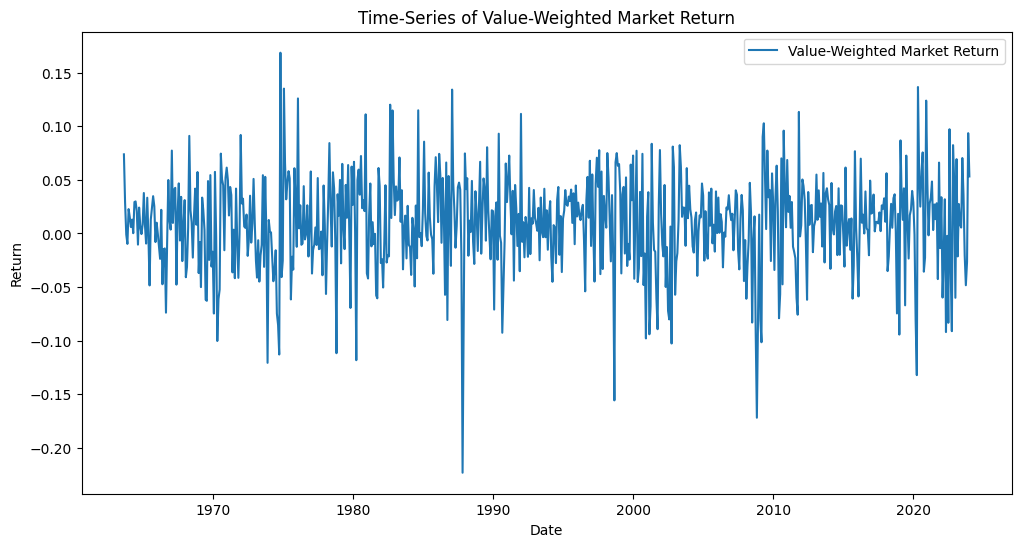

In [213]:
#Plot the Market Return

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(market_return['date'], market_return['VW_Market_Return'], label='Value-Weighted Market Return')
plt.xlabel('Date')
plt.ylabel('Return')
plt.title('Time-Series of Value-Weighted Market Return')
plt.legend()
plt.show()

Explanation of the Time-Series of the Value-Weighted Market Return

This plot represents the value-weighted market return over time, capturing the aggregate performance of the market. Each point on the graph corresponds to the return for a given period. 
    - R_t^market is the value-weighted market return at time.
    - ME_t-1 is the market equity (ME_company) of firm i at the previous period t-1.
    - R_i,t is the stock return (ret) of firm i at time t.

Key Observations from the Plot

1. Volatility Over Time
    The time series shows significant fluctuations, with periods of high volatility and market turbulence.
    Large negative spikes correspond to financial crises (e.g., 1987 Black Monday, 2008 Global Financial Crisis, and COVID-19 crash in 2020).

2. Influence of Market Equity (ME_company)
    Larger firms (higher 𝑀E_i,t-1) have a greater impact on the overall market return.
    When large-cap stocks experience significant returns, they drive the market return more than small-cap stocks.

3. Impact of Individual Returns (ret)
    If many firms have positive returns, the market return is positive and vice versa.
    Large firms with extreme returns (e.g., major crashes or booms) significantly impact the overall market movement.

4. Crisis and Market Shocks
    Some sharp negative drops indicate market crashes, likely corresponding to financial crises, external shocks, or economic downturns.
    The relatively stable periods suggest normal market conditions with moderate fluctuations.

Conclusion

This time-series provides a comprehensive view of market performance, highlighting how the returns of large firms influence the overall market. The weighting by market equity (ME_company) ensures that dominant firms drive the market return, making this a more realistic measure of market movements than an equal-weighted return.

### 6. Build the portfolios



#### 6.1 Classification by Fama and french (1993) 

1. Filter Companies with Positive Equity
Fama and French (1993) specify that firms with nonpositive book equity (BE) should be excluded when forming portfolios.

2. Compute Size and Book-to-Market Ratio
Size: Market equity (ME=prc×shrout) at the end of June of year t.
Book-to-Market (BM): BM=BE/ME using book equity from year t−1 and market equity from December of year t−1.

3. Define NYSE Breakpoints for Size and BM
Size: Median NYSE market equity at the end of June defines the breakpoint for "Small" (S) and "Big" (B).
BM: Breakpoints at the 30th and 70th percentiles for NYSE firms define "Low," "Medium," and "High" book-to-market stocks.

4. Assign Stocks to Portfolios
Combine size and BM labels into six groups:
Small-Low (SL), Small-Medium (SM), Small-High (SH)
Big-Low (BL), Big-Medium (BM), Big-High (BH)

5. Compute Portfolio Returns
Calculate monthly value-weighted returns from July t to June t+1.
Weigh individual stock returns by their lagged market equity.

In [220]:
import pandas as pd
import numpy as np

# Step 1: Filter firms with positive book equity
df_filtered = df_merged[df_merged['BE'] > 0].copy()


In [221]:
# Step 2: Compute Book-to-Market Ratio (BM)
df_filtered['B2M'] = df_filtered['BE'] / df_filtered['Market_Equity']

In [222]:
print(df_filtered.columns)

Index(['permno', 'permco', 'date', 'fyear', 'fyr', 'ceq', 'txditc', 'pstkl',
       'pstkrv', 'pstk', 'ret', 'retx', 'shrout', 'prc', 'cfacpr', 'shrcd',
       'exchcd', 'siccd', 'dlret', 'dlstcd', 'ret_adj', 'years_in_compustat',
       'PSTK', 'BE', 'Market_Equity', 'ME_company', 'obs_year', 'obs_month',
       'fye_month', 'BH', 'BL', 'BM', 'SH', 'SL', 'SM', 'ME_company_lag',
       'weighted_return', 'B2M'],
      dtype='object')


In [223]:
# Step 3: Identify June Size Breakpoints for NYSE

# Ensure 'date' is in datetime format
df_filtered['date'] = pd.to_datetime(df_filtered['date'])

# Extract the year and month from 'date'
df_filtered['year'] = df_filtered['date'].dt.year
df_filtered['month'] = df_filtered['date'].dt.month

# Filter for NYSE stocks in June
nyse_stocks = df_filtered[(df_filtered['exchcd'] == 1) & (df_filtered['month'] == 6)]

# Compute the NYSE median for size (size breakpoint)
size_breakpoint = nyse_stocks.groupby('year')['Market_Equity'].median()

# Ensure 'BM' is numeric
nyse_stocks['B2M'] = pd.to_numeric(nyse_stocks['B2M'], errors='coerce')

# Drop NaN values in BM before computing quantiles
nyse_stocks = nyse_stocks.dropna(subset=['B2M'])

# Compute the NYSE 30th and 70th percentiles for book-to-market (BM)
bm_30 = nyse_stocks.groupby('year')['B2M'].quantile(0.3)
bm_70 = nyse_stocks.groupby('year')['B2M'].quantile(0.7)

C:\Users\65610\AppData\Local\Temp\ipykernel_14612\222754514.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyse_stocks['B2M'] = pd.to_numeric(nyse_stocks['B2M'], errors='coerce')


In [224]:
# Step 4: Assign Stocks to Size and BM Portfolios

# Ensure mapping finds valid values; replace missing mappings with NaN
df_filtered['Size_Breakpoint'] = df_filtered['year'].map(size_breakpoint)

# Drop rows where Size_Breakpoint is NaN to avoid TypeError
df_filtered = df_filtered.dropna(subset=['Size_Breakpoint'])

# Now assign Small or Big based on the breakpoint
df_filtered['Size_Group'] = np.where(
    df_filtered['Market_Equity'] <= df_filtered['Size_Breakpoint'], 
    'Small', 
    'Big'
)

# Assign B2M groups safely
df_filtered['B2M_Group'] = df_filtered.apply(
    lambda row: ('Low' if row['B2M'] <= bm_30.get(row['year'], np.nan) else
                 'High' if row['B2M'] > bm_70.get(row['year'], np.nan) else
                 'Medium'), axis=1)

# Drop Size_Breakpoint column (no longer needed)
df_filtered.drop(columns=['Size_Breakpoint'], inplace=True)



In [225]:
# Step 5: Create Portfolio Labels
df_filtered['Portfolio'] = df_filtered['Size_Group'].str[0] + df_filtered['B2M_Group'].fillna('Missing').str[0]

# Ensure 'date' is in datetime format
df_filtered['date'] = pd.to_datetime(df_filtered['date'])

# Step 5.1: Compute Monthly Value-Weighted Returns (July t to June t+1)
df_filtered['Lag_ME'] = df_filtered.groupby('permno')['Market_Equity'].shift(1)  # Lagged ME for weighting

# Drop rows with missing return data or lagged market equity
df_filtered = df_filtered.dropna(subset=['ret', 'Lag_ME'])

# Compute portfolio returns efficiently
vw_returns = (
    df_filtered.groupby(['date', 'Portfolio'])
    .apply(lambda x: np.average(x['ret'], weights=x['Lag_ME']) if x['Lag_ME'].sum() > 0 else np.nan)
    .reset_index(name='Portfolio_Return')
)

# Pivot the table for easier analysis
vw_returns_pivot = vw_returns.pivot(index=['date'], columns='Portfolio', values='Portfolio_Return')

# Display results
print(vw_returns_pivot.head())


Portfolio         BH        BL        BM        SH        SL        SM
date                                                                  
1964-02-29 -0.002339  0.009718 -0.000448  0.007410 -0.026475  0.004311
1964-03-31  0.001930  0.012273  0.031565  0.019286 -0.076352  0.000386
1964-04-30 -0.071519  0.002310  0.023968 -0.004409 -0.016631 -0.022492
1964-05-31  0.039719  0.034120  0.025139 -0.003207  0.023011  0.026275
1964-06-30  0.045264  0.033611  0.006073  0.026467  0.046252  0.037368


C:\Users\65610\AppData\Local\Temp\ipykernel_14612\3523033621.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: np.average(x['ret'], weights=x['Lag_ME']) if x['Lag_ME'].sum() > 0 else np.nan)


1. Portfolio Definitions

    First letter: Size\
        B: Big market-cap firms\
        S: Small market-cap firms

    Second letter: Book-to-Market (B2M) (Book equity / Market capitalization) ratio (value vs. growth)\
        H: High B/M ("value" stocks)\
        L: Low B/M ("growth" stocks)\
        M: Medium B/M

2. Key Observations

    February 1964\
        SH (Small Value): +0.74%\
        SL (Small Growth): -2.65%\
        → Small growth stocks underperformed, while small value stocks did better.\
        BH (Big Value): -0.23%\
        BL (Big Growth): +0.97%\
        → Big growth outperformed big value.

    March 1964\
        BL (Big Growth): +1.23%\
        BM (Big Medium): +3.16%\
        SL (Small Growth): -7.64%\
        → Extreme divergence: Big caps (especially medium B/M) surged, while small growth crashed.

    April 1964\
        BH (Big Value): -7.15%\
        BL (Big Growth): +0.23%\
        → Big value stocks collapsed, while big growth held steady.\
        SH (Small Value): -0.44%\
        SL (Small Growth): -1.66%\
        → Broad small-cap weakness.

    May–June 1964\
        Broad recovery: Most portfolios rebounded.\
        SL (Small Growth): +2.30% in May, +4.63% in June\
        → Small growth stocks rebounded sharply.

3. Patterns and Anomalies

    Value vs. Growth:
        Small caps: Value (SH) outperformed growth (SL) in February but lagged in April.

    Big caps: 
        Growth (BL) generally outperformed value (BH) except in June.

    Size Effect: 
        Small caps (S) showed higher volatility (e.g., SL: -7.64% in March vs. +4.63% in June).
        Big caps (B) were more stable but still saw swings (e.g., BH: -7.15% in April).

    Market Conditions:
        Early 1964 saw choppy returns, possibly reflecting uncertainty (e.g., post-Kennedy assassination recovery, Fed policy shifts).
        Events like interest rate changes, geopolitical risks, or sector rotations could drive short-term noise.

#### 6.2 Verification

Verify that the book equity recorded for June 1999 stock observation will already include the book equity for the end of the fiscal year ending in September 1998.

In [227]:
import pandas as pd

# Extract observation year/month and fiscal year-end month
df_filtered['obs_year'] = df_filtered['date'].dt.year
df_filtered['obs_month'] = df_filtered['date'].dt.month
df_filtered['fye_month'] = df_filtered['fyr']  # Fiscal year-end month (e.g., 9 = September)

# Filter for June 1999 observations
june_1999_data = df_filtered[
    (df_filtered['obs_year'] == 1999) &
    (df_filtered['obs_month'] == 6)
]

# For companies with September fiscal year-end (fyr=9), check:
# 1. fyear=1998 (FYE Sept 1998)
# 2. BE is not missing
sep_fyr_mask = (june_1999_data['fye_month'] == 9)
correct_fyear_mask = (june_1999_data['fyear'] == 1998)
be_present_mask = june_1999_data['BE'].notna()

# Validate September fiscal year-end companies
valid_sep_fyr = june_1999_data[sep_fyr_mask]
all_valid = (
    valid_sep_fyr['fyear'].eq(1998).all() and  # All fyear=1998
    valid_sep_fyr['BE'].notna().all()          # No missing BE
)

if all_valid:
    print("Validation passed: June 1999 observations for September fiscal year-end companies correctly use BE from FYE Sept 1998.")
else:
    print("Validation failed. Investigate the following:")
    if not valid_sep_fyr['fyear'].eq(1998).all():
        print("- Some September fiscal year-end companies have fyear ≠ 1998.")
    if not valid_sep_fyr['BE'].notna().all():
        print("- Missing BE values for some September fiscal year-end companies.")

# Optional: Check lag between fiscal year-end and observation date (should be ≥3 months)
valid_sep_fyr['fye_date'] = pd.to_datetime(
    valid_sep_fyr['fyear'].astype(str) + '-' +
    valid_sep_fyr['fye_month'].astype(str) + '-30'
)
valid_sep_fyr['lag_months'] = (
    (valid_sep_fyr['date'] - valid_sep_fyr['fye_date']) / pd.Timedelta(days=30)
)
if (valid_sep_fyr['lag_months'] < 3).any():
    print("Warning: Some observations have <3 months lag between FYE and observation date.")

Validation passed: June 1999 observations for September fiscal year-end companies correctly use BE from FYE Sept 1998.


C:\Users\65610\AppData\Local\Temp\ipykernel_14612\1188515835.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_sep_fyr['fye_date'] = pd.to_datetime(
C:\Users\65610\AppData\Local\Temp\ipykernel_14612\1188515835.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_sep_fyr['lag_months'] = (


#### 6.3 Plot the share of stocks in each group over time

Because of the special role of NYSE, we will have to keep track of the variable exchcd.

In [228]:
df_filtered.describe()

,permno,permco,date,fyear,fyr,ceq,txditc,pstkl,pstkrv,pstk,...,BL,BM,SH,SL,SM,ME_company_lag,weighted_return,year,month,Lag_ME
count,2.573661e+06,2573661.0,2573661,2573661.0,2573661.0,2573661.0,2333199.0,2572590.0,2572540.0,2573049.0,...,0.0,0.0,0.0,0.0,0.0,2573661.0,2573661.0,2.573661e+06,2.573661e+06,2573661.0
mean,5.441888e+04,18084.597953,1996-10-25 04:21:14.299296256,1994.909562,9.706559,912.939258,116.460959,23.487843,23.767564,19.993557,...,NaN,NaN,NaN,NaN,NaN,2.598134,0.021605,1.996275e+03,6.538967e+00,2.589858
min,1.000100e+04,3.0,1964-02-29 00:00:00,1962.0,1.0,-371.0,-131.0,0.0,-18.4,-252.0,...,NaN,NaN,NaN,NaN,NaN,0.00004,-394.128682,1.964000e+03,1.000000e+00,0.00004
25%,2.733400e+04,6688.0,1985-04-30 00:00:00,1983.0,8.0,16.769,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0.025381,-0.00598,1.985000e+03,4.000000e+00,0.025368
50%,5.780900e+04,15031.0,1997-03-31 00:00:00,1995.0,12.0,68.649,0.348,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0.12023,0.0,1.997000e+03,7.000000e+00,0.12013
75%,8.024500e+04,22426.0,2008-01-31 00:00:00,2006.0,12.0,320.428,10.025,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0.685959,0.009867,2.008000e+03,1.000000e+01,0.685545
max,9.343600e+04,59277.0,2023-12-31 00:00:00,2023.0,12.0,506199.0,89679.0,70664.0,70664.0,70664.0,...,NaN,NaN,NaN,NaN,NaN,3071.344876,415.10045,2.023000e+03,1.200000e+01,3071.344876
std,2.759043e+04,14656.260338,NaN,14.629523,3.466013,6234.055051,1067.797378,439.203478,435.888441,417.260356,...,NaN,NaN,NaN,NaN,NaN,21.820991,1.812321,1.463509e+01,3.451480e+00,21.809555


In [229]:
# Number of observations for each variable
df_filtered.count()

permno                2573661
permco                2573661
date                  2573661
fyear                 2573661
fyr                   2573661
ceq                   2573661
txditc                2333199
pstkl                 2572590
pstkrv                2572540
pstk                  2573049
ret                   2573661
retx                  2573661
shrout                2573661
prc                   2573661
cfacpr                2573661
shrcd                 2573661
exchcd                2573661
siccd                 2573661
dlret                    1744
dlstcd                   1788
ret_adj               2573661
years_in_compustat    2573661
PSTK                  2573661
BE                    2573661
Market_Equity         2573661
ME_company            2573661
obs_year              2573661
obs_month             2573661
fye_month             2573661
BH                          0
BL                          0
BM                          0
SH                          0
SL        

In [93]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [230]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Step 1: Create a Date Column
# Combine 'year' and 'month' into a datetime column (set day=1 for convenience)
df_filtered['date'] = pd.to_datetime(df_filtered['year'].astype(str) + '-' + 
                                     df_filtered['month'].astype(str) + '-01')

In [231]:
# Step 2: Label the Exchange
# For example, assume exchcd==1 indicates NYSE; all others are considered "Non-NYSE"
df_filtered['Exchange'] = df_filtered['exchcd'].apply(lambda x: 'NYSE' if x == 1 else 'Non-NYSE')

In [232]:
# Step 3: Count Stocks by Date, Portfolio, and Exchange
# Count the number of stocks in each group (per date, portfolio, and exchange)
group_counts = (
    df_filtered.groupby(['date', 'Portfolio', 'Exchange'])
    .size()
    .reset_index(name='stock_count')
)

# Also count the total number of stocks for each date and exchange
total_counts = (
    df_filtered.groupby(['date', 'Exchange'])
    .size()
    .reset_index(name='total_stocks')
)

# Merge the two counts so we can compute the share
group_counts = pd.merge(group_counts, total_counts, on=['date', 'Exchange'])
group_counts['share'] = group_counts['stock_count'] / group_counts['total_stocks']

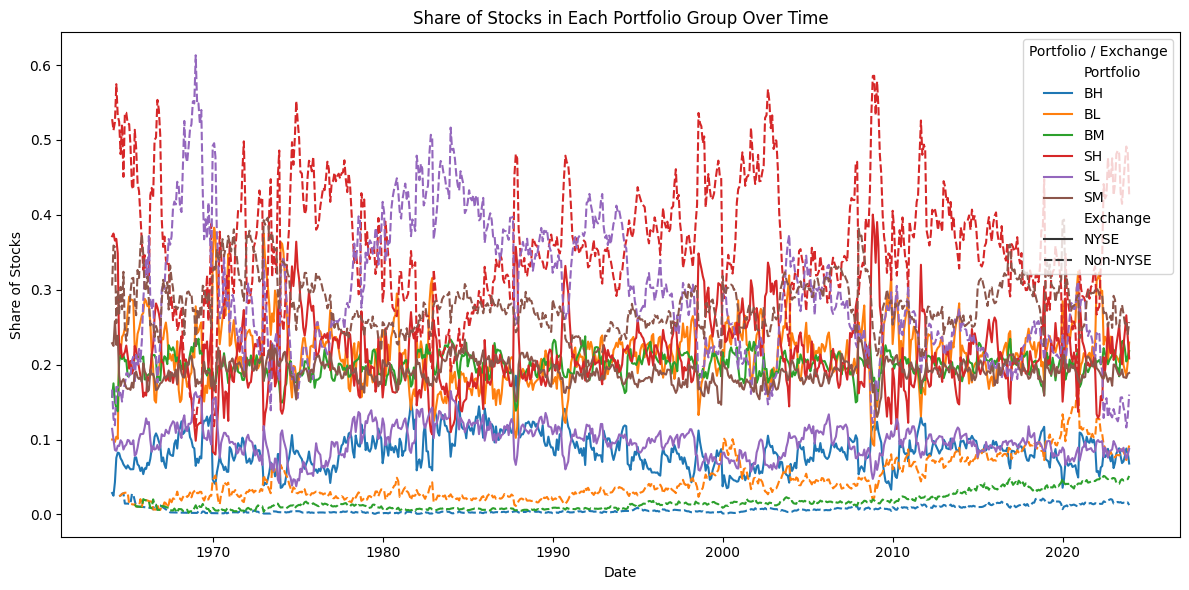

In [233]:
# Step 4: Plot the Shares Over Time
# Option 1: Plot all exchanges together with different colors for portfolios.
plt.figure(figsize=(12, 6))
sns.lineplot(data=group_counts, x='date', y='share', hue='Portfolio', style='Exchange')
plt.title('Share of Stocks in Each Portfolio Group Over Time')
plt.xlabel('Date')
plt.ylabel('Share of Stocks')
plt.legend(title='Portfolio / Exchange', loc='upper right')
plt.tight_layout()
plt.show()

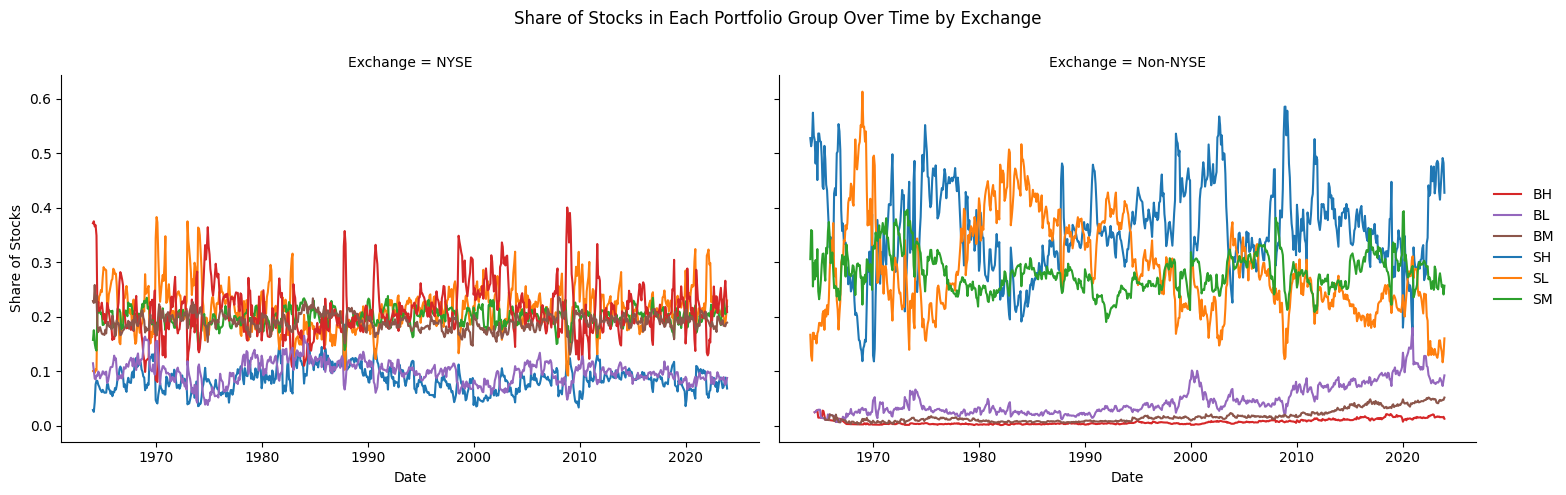

In [234]:
# Option 2: Facet the plot by Exchange (i.e. NYSE vs. Non-NYSE)
g = sns.FacetGrid(group_counts, col='Exchange', height=5, aspect=1.5, sharey=True)
g.map_dataframe(sns.lineplot, x='date', y='share', hue='Portfolio')
g.add_legend()
g.set_axis_labels("Date", "Share of Stocks")
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('Share of Stocks in Each Portfolio Group Over Time by Exchange')
plt.show()

Explanation of the plots

1. Left Panel (Exchange = NYSE):
    The lines show significant fluctuations over time, but overall, the shares remain relatively stable, with no single portfolio dominating consistently.\ There are occasional sharp spikes or dips, indicating periods of rebalancing or market shifts affecting the composition of these portfolios on the NYSE.

2. Right Panel (Exchange = Non-NYSE):
    The portfolios exhibit more volatility and variability compared to the NYSE panel.\
    The shares of stocks in these portfolios fluctuate more dramatically, with some portfolios (e.g., SH in blue) showing sharp peaks and troughs, while others (e.g., BH in red) remain relatively flat or have smaller changes.\
    Toward the later years (around 2010–2020), there’s a noticeable decline in some portfolio shares (e.g., SH and SM), suggesting a shift in the composition or market dynamics for non-NYSE stocks.

Key Observations

1. NYSE vs. Non-NYSE Differences: Stocks on the NYSE (left panel) appear to have more stable portfolio shares over time, with less extreme fluctuations compared to non-NYSE stocks (right panel). This could reflect the NYSE’s role as a more established exchange with larger, more stable companies, while non-NYSE exchanges (e.g., NASDAQ) may include more smaller, growth-oriented, or volatile companies.

2. Portfolio Dynamics: The Fama-French portfolios (SL, SM, SH, BL, BM, BH) show varying levels of prominence. For instance, small-cap portfolios (SL, SM, SH) might have higher volatility, especially on non-NYSE exchanges, while big-cap portfolios (BL, BM, BH) tend to have more consistent shares, particularly on the NYSE.

3. Temporal Trends: Both panels show changes over decades, with potential influences from market events (e.g., dot-com bubble, financial crisis of 2008). The non-NYSE panel shows more sensitivity to these events, as seen in the sharper peaks and troughs.

The greater stability on the NYSE suggests that larger, more established companies (big-cap) dominate its listings, while non-NYSE exchanges host more dynamic, smaller, or growth-oriented companies, leading to higher volatility in portfolio shares. The fluctuations could reflect changes in market conditions, investor preferences, or the reclassification of stocks into different size and value categories over time.

In [198]:
df_merged.to_csv('df_merged')

In [235]:
df_filtered.to_csv('df_filtered')

In [200]:
min_date = df_merged['date'].min()
print(min_date)

1963-07-31 00:00:00


In [236]:
min_date = df_filtered['date'].min()
print(min_date)

1964-02-01 00:00:00


#### 6.4 Select the corners of the 2x3 matrix

(see analysis done in 6.1)

In [238]:
# Select only the corner portfolios (Small-Low, Small-High, Big-Low, Big-High)
corner_portfolios = ['SL', 'SH', 'BL', 'BH']
vw_returns_pivot_corners = vw_returns_pivot[corner_portfolios]

# Display results
print(vw_returns_pivot_corners.head())

Portfolio         SL        SH        BL        BH
date                                              
1964-02-29 -0.026475  0.007410  0.009718 -0.002339
1964-03-31 -0.076352  0.019286  0.012273  0.001930
1964-04-30 -0.016631 -0.004409  0.002310 -0.071519
1964-05-31  0.023011 -0.003207  0.034120  0.039719
1964-06-30  0.046252  0.026467  0.033611  0.045264


In [ ]:
# Display the mean and standard deviation of the the corner portfolios (Small-Low, Small-High, Big-Low, Big-High)

print("Mean Returns:")
print(vw_returns_pivot_corners.mean())
print("\nStandard Deviation:")
print(vw_returns_pivot_corners.std())


Mean Returns:
Portfolio
SL    0.013158
SH   -0.012168
BL    0.013970
BH   -0.000605
dtype: float64

Standard Deviation:
Portfolio
SL    0.066877
SH    0.063013
BL    0.046425
BH    0.054667
dtype: float64


In [ ]:
import pandas as pd
import numpy as np

# Define portfolio names explicitly
portfolios = ['BH', 'BL', 'BM', 'SH', 'SL', 'SM']

# Ensure all portfolios are included in the pivoted DataFrame
for port in portfolios:
    if port not in vw_returns_pivot.columns:
        vw_returns_pivot[port] = np.nan  # Fill missing portfolios with NaN

# Ensure dataframe is sorted by date
vw_returns_pivot = vw_returns_pivot.sort_values(by='date')

# Display only date and the six portfolio columns
print(vw_returns_pivot[['date'] + portfolios].head())


Portfolio       date        BH        BL        BM        SH        SL  \
0         1964-02-29 -0.002339  0.009718 -0.000448  0.007410 -0.026475   
1         1964-03-31  0.001930  0.012273  0.031565  0.019286 -0.076352   
2         1964-04-30 -0.071519  0.002310  0.023968 -0.004409 -0.016631   
3         1964-05-31  0.039719  0.034120  0.025139 -0.003207  0.023011   
4         1964-06-30  0.045264  0.033611  0.006073  0.026467  0.046252   

Portfolio        SM  
0          0.004311  
1          0.000386  
2         -0.022492  
3          0.026275  
4          0.037368  


In [259]:
print(vw_returns_pivot.head())

Portfolio  index       date        BH        BL        BM        SH        SL  \
0              0 1964-02-29 -0.002339  0.009718 -0.000448  0.007410 -0.026475   
1              1 1964-03-31  0.001930  0.012273  0.031565  0.019286 -0.076352   
2              2 1964-04-30 -0.071519  0.002310  0.023968 -0.004409 -0.016631   
3              3 1964-05-31  0.039719  0.034120  0.025139 -0.003207  0.023011   
4              4 1964-06-30  0.045264  0.033611  0.006073  0.026467  0.046252   

Portfolio        SM  
0          0.004311  
1          0.000386  
2         -0.022492  
3          0.026275  
4          0.037368  


In [275]:
# List of columns to multiply
columns_to_multiply = ['BH', 'BL', 'BM', 'SH', 'SL', 'SM']

# Multiply the specified columns by 100
vw_returns_pivot[columns_to_multiply] = vw_returns_pivot[columns_to_multiply] * 100

# Display the updated DataFrame
print(vw_returns_pivot.head())


Portfolio       date        BH        BL        BM        SH        SL  \
0         1964-02-29 -0.233886  0.971758 -0.044823  0.741003 -2.647519   
1         1964-03-31  0.193034  1.227346  3.156498  1.928580 -7.635226   
2         1964-04-30 -7.151893  0.231008  2.396842 -0.440870 -1.663121   
3         1964-05-31  3.971912  3.412047  2.513900 -0.320733  2.301057   
4         1964-06-30  4.526395  3.361063  0.607264  2.646682  4.625232   

Portfolio        SM  
0          0.431099  
1          0.038616  
2         -2.249151  
3          2.627529  
4          3.736776  


In [277]:
vw_returns_pivot.describe()

Portfolio,date,BH,BL,BM,SH,SL,SM
count,719,719.000000,719.000000,719.000000,719.000000,719.000000,719.000000
mean,1994-01-29 14:43:13.602225280,-0.060470,1.397033,0.705982,-1.216784,1.315841,0.332634
min,1964-02-29 00:00:00,-27.895400,-22.122830,-21.787369,-37.320643,-31.364362,-31.150563
25%,1979-02-14 00:00:00,-2.980766,-1.171229,-1.728703,-4.374207,-2.740769,-2.859325
50%,1994-01-31 00:00:00,0.193034,1.495995,0.966868,-0.791231,1.730554,0.846661
75%,2009-01-15 12:00:00,3.273181,4.365763,3.161533,2.354836,5.424838,3.637062
max,2023-12-31 00:00:00,21.472028,22.002069,14.316492,29.035859,20.569404,26.135693
std,NaN,5.466736,4.642494,4.343663,6.301270,6.687721,5.615738


In [278]:
# Save vw_returns_pivot as an excel file
vw_returns_pivot.to_excel('vw_returns_pivot.xlsx', index=False)

#### 6.5 Rationale for construction of book-to-market portfolios

Risk and Return Differences

Firms with different book-to-market (B/M) ratios exhibit systematic differences in returns.\
High B/M firms (value stocks) tend to have higher average returns than low B/M firms (growth stocks).\
This suggests that B/M captures some form of risk exposure or mispricing.

Why This Definition Does Not Entail Look-Ahead Bias?

Look-ahead bias occurs when future information is inadvertently used in constructing portfolios, leading to unrealistic results. This method avoids look-ahead bias because:

1. Book Value is Measured at the Prior Year-End
    
    The book value of equity (B) is taken from the firm’s last available financial statement, typically at the end of the previous fiscal year (December of year t-1).
    This ensures that book values are known before stock returns are measured.

2. Market Equity is Measured at June t

    Market equity (M) is computed at the end of June of year t, ensuring that sorting is done only using past information.
    This prevents the use of future price movements when forming the portfolios.
    
3. Portfolio Returns Are Computed from July t to June t+1

    Stocks are assigned to portfolios in June of year t based on prior B/M ratios.
    Portfolio returns are measured from July of year t to June of year t+1, ensuring no forward-looking bias.

The Journal of FinanceVolume 47, Issue 2 p. 427-465
The Cross-Section of Expected Stock Returns
EUGENE F. FAMA, KENNETH R. FRENCH
First published: June 1992
https://doi.org/10.1111/j.1540-6261.1992.tb04398.x

"We use a firm's market equity at the end of December of year t-1 to compute its book-to-market, leverage, and earnings-price ratios for t-1, and we use its market equity for June of year t to measure its size. Thus, to be included in the return tests for July of year t, a firm must have a CRSP stock price for December of year t-1 and June of year t. It must also have monthly returns for at least 24 of the 60 months preceding July of year t (for “pre-ranking” β estimates, discussed below). And the firm must have COMPUSTAT data on total book assets (A), book equity (BE), and earnings (E), for its fiscal year ending in (any month of) calendar year t-1.

Our use of December market equity in the E/P, BE/ME, and leverage ratios is objectionable for firms that do not have December fiscal yearends because the accounting variable in the numerator of a ratio is not aligned with the market value in the denominator. Using ME at fiscal yearends is also problematic; then part of the cross-sectional variation of a ratio for a given year is due to market-wide variation in the ratio during the year. For example, if there is a general fall in stock prices during the year, ratios measured early in the year will tend to be lower than ratios measured later. We can report, however, that the use of fiscal-yearend MEs, rather than December MEs, in the accounting ratios has little impact on our return tests.

Finally, the tests mix firms with different fiscal yearends. Since we match accounting data for all fiscal yearends in calendar year t-1 with returns for July of t to June of t+1, the gap between the accounting data and the matching returns varies across firms. We have done the tests using the smaller sample of firms with December fiscal yearends with similar results."


Predicting Anomalies
Boone Bowles, Adam V. Reed,
Matthew C. Ringgenberg, and Jacob R. Thornock∗
August 2024

https://jhfinance.web.unc.edu/wp-content/uploads/sites/12369/2024/11/Predicting-Anomalies.pdf

"We show that stock returns follow predictable patterns before the publication of anomaly trading signals. Moreover, anomaly trading signals derived from financial data are themselves predictable, making it possible to trade before financial statements are released. A
trading strategy based on predicted signals earns an annualized return of 3.65% in the quarter before the signal is released. In recent periods this predictability is concentrated in signals
that are harder to forecast and returns are increasingly earned several quarters before signals are released. Our findings suggest anomalies are more anomalous than previously recognized."

Key Findings:

1. Anomaly signals (e.g., B/M ratios) can be predicted before financial statements are released.

2. A trading strategy based on predicted signals earns 3.65% annualized returns in the quarter preceding official signal publication.

3. Returns increasingly accrue several quarters before signals are released, especially for harder-to-forecast anomalies.

The rationale for the construction of the book-to-market portfolios does not account for look-ahead bias. Discuss this assumption in light of Bowles et al. (2024):

The assumption in Fama and French (1992) that book-to-market (B/M) portfolio construction avoids look-ahead bias hinges on using only publicly available accounting data at the time of portfolio formation. However, Bowles et al. (2024) challenge this premise by demonstrating that anomaly signals—including those tied to accounting-based metrics like B/M—are predictable before their official publication.

--> Markets anticipate accounting-based signals using alternative data (e.g., preliminary earnings, news sentiment, or machine learning models).

In short: The assumption of no look-ahead bias in Fama and French (1992) is valid technically but incomplete economically: markets are smarter than the calendar.

### 7. other data

#### 7.1 Importing other data

In [ ]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [279]:
# Read other_data.xlsx file sheet "6_Portfolios_2x3"
df_portfolios = pd.read_excel('other_data.xlsx', sheet_name='6_Portfolios_2x3')
print('Shape of other_data dataset:', df_portfolios.shape)
df_portfolios.head()
 
# Print data type of date column in df_other_data
print("Data type of date column in df_portfolios:", df_portfolios['date'].dtype)
 
if not pd.api.types.is_datetime64_any_dtype(df_portfolios['date']):
    # Convert the int64 dates to strings
    df_portfolios['date'] = df_portfolios['date'].astype(str)
    # Parse as year-month (YYYYMM) and convert to the last day of the month
    df_portfolios['date'] = pd.to_datetime(df_portfolios['date'], format='%Y%m') + pd.offsets.MonthEnd(0)
 
# Verify the transformation
print(df_portfolios.head())


Shape of other_data dataset: (1182, 7)
Data type of date column in df_portfolios: int64
        date      SL      SM      SH      BL      BM      BH
0 1926-07-31  1.0874  0.9081 -0.0695  5.7168  1.8971  2.0066
1 1926-08-31  0.7030  1.5075  5.3842  2.7154  2.7196  5.6796
2 1926-09-30 -2.9117 -0.1359 -0.4374  1.4287  0.0808 -0.7928
3 1926-10-31 -3.8196 -4.3572 -2.0112 -3.5898 -2.3377 -3.9998
4 1926-11-30  3.1806  3.6608  2.0944  3.1292  2.9242  3.1934


In [280]:
# Read other_data.xlsx file sheet "RF"
df_market_rf_data = pd.read_excel('other_data.xlsx', sheet_name='RF')
print('Shape of market_rf dataset:', df_market_rf_data.shape)
df_market_rf_data.head()
 
# Only transform if 'date' column doesn't exist or isn't datetime64[ns]
if 'date' not in df_market_rf_data.columns or not pd.api.types.is_datetime64_any_dtype(df_market_rf_data['date']):
    # Combine 'year' and 'month' into a YYYYMM integer, then convert to datetime64[ns] for the end of the month
    df_market_rf_data['date'] = (df_market_rf_data['year'].astype(str) +
                                 df_market_rf_data['month'].astype(str).str.zfill(2)).astype(int).astype(str)
    df_market_rf_data['date'] = pd.to_datetime(df_market_rf_data['date'], format='%Y%m') + pd.offsets.MonthEnd(0)
   
    # Drop the original 'year' and 'month' columns
    df_market_rf_data = df_market_rf_data.drop(columns=['year', 'month'])
 
# Reorder columns to place 'date' first
df_market_rf_data = df_market_rf_data[['date', 'Mkt-RF', 'RF', 'RM']]
 
print(df_market_rf_data.head())


Shape of market_rf dataset: (726, 5)
        date  Mkt-RF    RF    RM
0 1963-07-31   -0.39  0.27 -0.12
1 1963-08-31    5.07  0.25  5.32
2 1963-09-30   -1.57  0.27 -1.30
3 1963-10-31    2.53  0.29  2.82
4 1963-11-30   -0.85  0.27 -0.58


In [281]:
df_other = df_market_rf_data.merge(df_portfolios, on='date')


In [282]:
df_other

,date,Mkt-RF,RF,RM,SL,SM,SH,BL,BM,BH
0,1963-07-31,-0.39,0.27,-0.12,-0.9960,-0.5976,-1.1202,-0.0411,0.5459,-1.8554
1,1963-08-31,5.07,0.25,5.32,4.5361,4.4852,5.7786,5.3890,4.6233,7.7374
2,1963-09-30,-1.57,0.27,-1.30,-3.0338,-0.5782,-1.9949,-1.0644,-1.7019,-1.8500
3,1963-10-31,2.53,0.29,2.82,1.2001,1.5438,2.7144,3.8445,1.2355,2.1333
4,1963-11-30,-0.85,0.27,-0.58,-2.9288,-1.2360,-0.3615,-0.2458,-1.4530,0.6863
...,...,...,...,...,...,...,...,...,...,...
721,2023-08-31,-2.39,0.45,-1.94,-7.8751,-5.5124,-5.4211,-0.8988,-2.8145,-5.5092
722,2023-09-30,-5.24,0.43,-4.81,-6.6697,-5.9003,-6.0829,-5.4008,-2.7017,-3.0848
723,2023-10-31,-3.19,0.47,-2.72,-9.1296,-6.0649,-6.2201,-1.7960,-3.6388,-4.3317
724,2023-11-30,8.84,0.44,9.28,9.8092,9.0710,10.4724,9.5666,7.6417,12.2209


In [283]:
df_other.describe()

,date,Mkt-RF,RF,RM,SL,SM,SH,BL,BM,BH
count,726,726.000000,726.000000,726.000000,726.000000,726.000000,726.000000,726.000000,726.000000,726.000000
mean,1993-10-15 01:59:00.495867776,0.568099,0.362727,0.930826,0.919546,1.229398,1.349464,0.942671,0.918346,1.097363
min,1963-07-31 00:00:00,-23.240000,0.000000,-22.640000,-32.482900,-27.891500,-28.085800,-23.215800,-20.322300,-27.226700
25%,1978-09-07 12:00:00,-2.007500,0.140000,-1.742500,-3.198250,-1.771950,-1.527500,-1.714575,-1.559925,-1.662050
50%,1993-10-15 12:00:00,0.915000,0.380000,1.265000,1.198800,1.492600,1.685200,1.128450,1.228150,1.313250
75%,2008-11-22 12:00:00,3.437500,0.500000,3.810000,5.040450,4.559600,4.659200,3.841775,3.477225,4.272300
max,2023-12-31 00:00:00,16.100000,1.350000,16.610000,28.088300,26.742400,30.693500,21.243500,16.933500,21.277100
std,NaN,4.497354,0.265504,4.482942,6.834961,5.522397,5.791296,4.638883,4.342084,5.094622


In [289]:
# Save df_other_data as an excel file
df_other.to_excel('df_other.xlsx', index=False)

In [285]:
# Rename SL to SL_other, SM to SM_other, SH to SH_other, BL to BL_other, BM to BM_other, and BH to BH_other in df_other
df_other.columns = df_other.columns.str.replace('SL', 'SL_other').str.replace('SM', 'SM_other').str.replace('SH', 'SH_other').str.replace('BL', 'BL_other').str.replace('BM', 'BM_other').str.replace('BH', 'BH_other')


In [286]:
df_other.describe()

,date,Mkt-RF,RF,RM,SL_other,SM_other,SH_other,BL_other,BM_other,BH_other
count,726,726.000000,726.000000,726.000000,726.000000,726.000000,726.000000,726.000000,726.000000,726.000000
mean,1993-10-15 01:59:00.495867776,0.568099,0.362727,0.930826,0.919546,1.229398,1.349464,0.942671,0.918346,1.097363
min,1963-07-31 00:00:00,-23.240000,0.000000,-22.640000,-32.482900,-27.891500,-28.085800,-23.215800,-20.322300,-27.226700
25%,1978-09-07 12:00:00,-2.007500,0.140000,-1.742500,-3.198250,-1.771950,-1.527500,-1.714575,-1.559925,-1.662050
50%,1993-10-15 12:00:00,0.915000,0.380000,1.265000,1.198800,1.492600,1.685200,1.128450,1.228150,1.313250
75%,2008-11-22 12:00:00,3.437500,0.500000,3.810000,5.040450,4.559600,4.659200,3.841775,3.477225,4.272300
max,2023-12-31 00:00:00,16.100000,1.350000,16.610000,28.088300,26.742400,30.693500,21.243500,16.933500,21.277100
std,NaN,4.497354,0.265504,4.482942,6.834961,5.522397,5.791296,4.638883,4.342084,5.094622


In [287]:
# Merge df_other and vw_returns_pivot based on 'date'

df_final = df_other.merge(vw_returns_pivot, on='date')

In [288]:
df_final.describe()

,date,Mkt-RF,RF,RM,SL_other,SM_other,SH_other,BL_other,BM_other,BH_other,BH,BL,BM,SH,SL,SM
count,719,719.000000,719.000000,719.000000,719.000000,719.000000,719.000000,719.000000,719.000000,719.000000,719.000000,719.000000,719.000000,719.000000,719.000000,719.000000
mean,1994-01-29 14:43:13.602225280,0.561307,0.363561,0.924868,0.928661,1.232118,1.349861,0.934311,0.914747,1.092102,-0.060470,1.397033,0.705982,-1.216784,1.315841,0.332634
min,1964-02-29 00:00:00,-23.240000,0.000000,-22.640000,-32.482900,-27.891500,-28.085800,-23.215800,-20.322300,-27.226700,-27.895400,-22.122830,-21.787369,-37.320643,-31.364362,-31.150563
25%,1979-02-14 00:00:00,-2.030000,0.140000,-1.750000,-3.208950,-1.842350,-1.539000,-1.740100,-1.567300,-1.656200,-2.980766,-1.171229,-1.728703,-4.374207,-2.740769,-2.859325
50%,1994-01-31 00:00:00,0.910000,0.380000,1.260000,1.221000,1.499800,1.689200,1.124400,1.220800,1.300000,0.193034,1.495995,0.966868,-0.791231,1.730554,0.846661
75%,2009-01-15 12:00:00,3.445000,0.500000,3.835000,5.088450,4.605200,4.671900,3.860200,3.481100,4.276350,3.273181,4.365763,3.161533,2.354836,5.424838,3.637062
max,2023-12-31 00:00:00,16.100000,1.350000,16.610000,28.088300,26.742400,30.693500,21.243500,16.933500,21.277100,21.472028,22.002069,14.316492,29.035859,20.569404,26.135693
std,NaN,4.513667,0.266655,4.499293,6.863353,5.545877,5.813493,4.655627,4.357732,5.110440,5.466736,4.642494,4.343663,6.301270,6.687721,5.615738


In [291]:
# Save df_final as an excel file
df_final.to_excel('df_final.xlsx', index=False)

#### 7.2 Plot the time-series of the return difference between the derived portfolio (above) and French's (in other data).

In [293]:
# List of portfolio names
portfolios = ['SL', 'SM', 'SH', 'BL', 'BM', 'BH']

# Compute the return differences
for port in portfolios:
    df_final[f'{port}_diff'] = df_final[port] - df_final[f'{port}_other']

# Display the first few rows
print(df_final.head())

        date  Mkt-RF    RF    RM  SL_other  SM_other  SH_other  BL_other  \
0 1964-02-29    1.54  0.26  1.80    1.5955    2.1794    4.1435    1.4253   
1 1964-03-31    1.41  0.31  1.72    0.5705    3.8882    5.1951    0.9246   
2 1964-04-30    0.10  0.29  0.39   -1.7606   -0.4077   -1.4626    0.4194   
3 1964-05-31    1.42  0.26  1.68    0.9717    1.1988    2.0641    1.5106   
4 1964-06-30    1.27  0.30  1.57    1.3983    1.5625    1.9892    1.6666   

   BM_other  BH_other  ...        BM        SH        SL        SM   SL_diff  \
0    1.6582    4.4977  ... -0.044823  0.741003 -2.647519  0.431099 -4.243019   
1    3.0113    3.1099  ...  3.156498  1.928580 -7.635226  0.038616 -8.205726   
2    1.2053   -1.2104  ...  2.396842 -0.440870 -1.663121 -2.249151  0.097479   
3    1.1688    4.1377  ...  2.513900 -0.320733  2.301057  2.627529  1.329357   
4    1.3153    2.3232  ...  0.607264  2.646682  4.625232  3.736776  3.226932   

    SM_diff   SH_diff   BL_diff   BM_diff   BH_diff  
0 -1.748

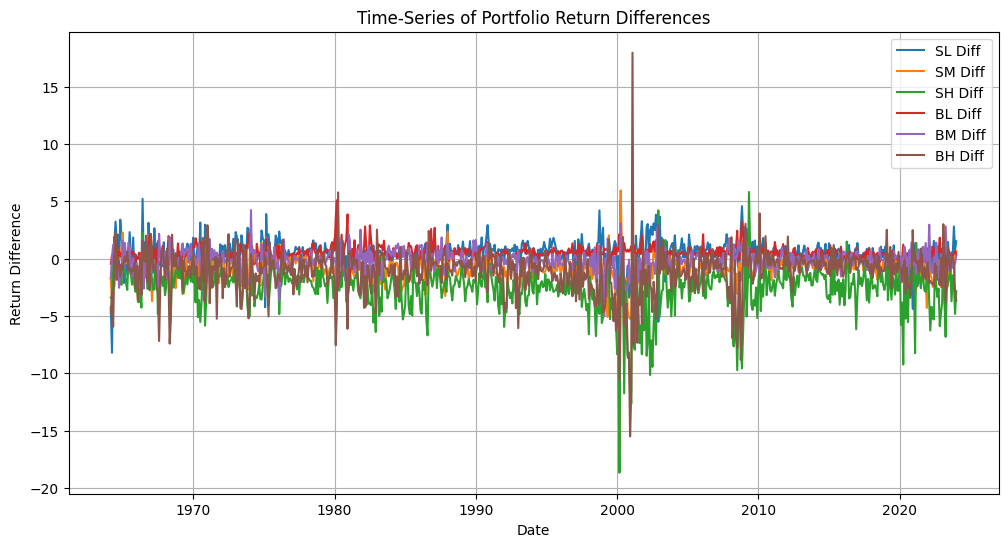

In [294]:
import matplotlib.pyplot as plt

# List of portfolio names
portfolios = ['SL', 'SM', 'SH', 'BL', 'BM', 'BH']

# Set figure size
plt.figure(figsize=(12, 6))

# Loop through each portfolio and plot its return difference
for port in portfolios:
    plt.plot(df_final['date'], df_final[f'{port}_diff'], label=f'{port} Diff')

# Formatting the plot
plt.xlabel('Date')
plt.ylabel('Return Difference')
plt.title('Time-Series of Portfolio Return Differences')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

#### 7.3 Why do you think that the two do not match perfectly?

### 8. Exercises

#### 8.1 Discussion of questions asked in the data-cleaning section

1. Explain the rationale for adjusting the returns for delisted stocks and for adjusting the inclusion of firms after two years of existence only. [page 2]

2. Report a plot of the share of stocks in each group over time. [page 4]

3. Report the corners of the 2x3 matrix.

4. Explain the rationale for the construction of the book-to-market portfolios. Why does this definition not entail look-ahead bias? Discuss the assumption in light of Bowles et al. (2024).

5. Report a plot of the time-serires of return differences between my portfolio and the other data (French's). Why do you think the two do not match perfectly?


#### 8.2 

1. Estimate the vector of sample mean excess returns and the covariance matrix of excess returns for each of the six assets. 

2. Use these estimates to compute two ex-post mean-variance efficient sets: one for portfolios not including the riskless asset, and one including the riskless asset (to draw the frontiers use the standard formulas in the lecture notes, and use the average of the risk-free rates to compute a constant rf ). 

3. Plot the two sets on a graph with the standard deviation of excess returns on the horizontal axis and the mean excess return on the vertical axis, and indicate where each of the four Fama-French portfolios and the market portfolio lie. 

4. Calculate the Sharpe ratios of the tangency portfolio and of the market portfolio in your data. 

5. Discuss.

#### 8.3

Plot expected return against beta for each of the portfolios (the securities market line).

Calculate alphas and discuss your results.


#### 8.4

Run the regressions below with OLS for each of the four portfolios P to estimate alpha_P and beta_P. 

Report your estimates (including standard errors) and discuss. 

As a side note, in Empirical Asset Pricing you will discuss testing the significance of each portfolio’s alpha jointly:
RP,t − Rf,t = αP + βP (RM,t − Rf,t) + εP,t.
